<h1>Содержание<span class="tocSkip"></span></h1>
</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [16]:
import pandas as pd
import numpy as np

import torch
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from nltk.stem import WordNetLemmatizer 

import re
import nltk
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from pymystem3 import Mystem
import spacy
from tqdm import tqdm

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


Замечен странный столбец, в котором дублируются индексы. Удалим его.

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)

In [5]:
data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Проверим датафрейм на наличие дубликатов

In [6]:
data['text'].duplicated().sum()

0

In [7]:
data.isnull().sum()

text     0
toxic    0
dtype: int64

Итого был удален ненужный столбец с повторной индексацией, а также произведена проверка на наличие дубликатов. Дубликаты не выявлены.

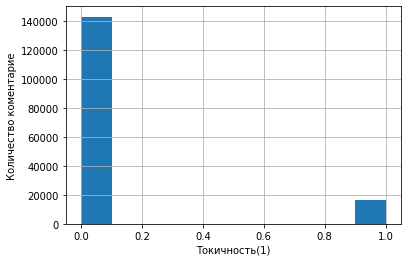

In [8]:
data['toxic'].hist()
plt.ylabel('Количество коментарие')
plt.xlabel('Токичность(1)')
plt.show()

In [9]:
nltk.download('stopwords')
count_vect = CountVectorizer() 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
stopwords = set(stopwords.words('english'))

Лемматизируем все текстовые выражения, для более удобной дальнейшей работы с ними. Отдельно создадим столбец для новых текстов.

In [11]:
def regul(text):
    t = re.sub(r'[^a-zA-z ]',' ',text)
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stopwords]
    t1 = " ".join(t.split())
    return t1

In [12]:
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])

In [13]:
def lemmatize(text):
    doc = load_model(text)
    l_t = " ".join([token.lemma_ for token in doc])
    return l_t

In [14]:
data['clear_text'] = data['text'].apply(lambda x: regul(x))
display(data.head())

,text,toxic,clear_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


In [17]:
tqdm.pandas()
 
data['lemm_text'] = data['clear_text'].progress_apply(lemmatize)
display(data.head(8))

100%|██████████| 159292/159292 [17:16<00:00, 153.66it/s]


,text,toxic,clear_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,you sir be my hero any chance you remember wha...
5,"""\n\nCongratulations from me as well, use the ...",0,Congratulations from me as well use the tools ...,congratulation from I as well use the tool wel...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,COCKSUCKER before you pis around on my work
7,Your vandalism to the Matt Shirvington article...,0,Your vandalism to the Matt Shirvington article...,your vandalism to the Matt Shirvington article...


После преобразования текста проверим новый датафрейм на наличие дубликатов по двум столбцам

In [18]:
duplicateRows = data[data.duplicated(['clear_text', 'toxic'])]
duplicateRows.count()

text          1119
toxic         1119
clear_text    1119
lemm_text     1119
dtype: int64

Было найдено 1320 дубликатов, их надо удалить.

In [19]:
data.drop_duplicates(subset=['clear_text', 'toxic'], inplace=True)

In [20]:
data.head(10)

,text,toxic,clear_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,you sir be my hero any chance you remember wha...
5,"""\n\nCongratulations from me as well, use the ...",0,Congratulations from me as well use the tools ...,congratulation from I as well use the tool wel...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,COCKSUCKER before you pis around on my work
7,Your vandalism to the Matt Shirvington article...,0,Your vandalism to the Matt Shirvington article...,your vandalism to the Matt Shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,Sorry if the word nonsense was offensive to yo...,sorry if the word nonsense be offensive to you...
9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...,alignment on this subject and which be contrar...


In [21]:
df = data.copy()

Разделим исходный датасет на тренировочную и тестовую выборку

In [22]:
x = df.drop(['toxic'], axis = 1)
y = df['toxic']

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y)

Теперь данные готовы для обучения модели.

## Обучение

Для автоматизации процесса создания пайплайнов для каждой модели, создадим функцию которая будет делать это за нас.

In [24]:
def pipelines(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', model)])
    randomized_search = RandomizedSearchCV(
        pipeline, 
        params, 
        cv=5,
        scoring='f1',
        random_state=42,
        n_jobs=-1)
    
    randomized_search.fit(x_train['clear_text'], y_train)
    print('Лучший результат метрики F1:', randomized_search.best_score_)
    print('Лучшие параметры модели:', randomized_search.best_params_)
    return randomized_search

In [25]:
model1 = LogisticRegression()
model2 = DecisionTreeClassifier()
model3 = CatBoostClassifier()

In [26]:
lr_mod = pipelines(model1, {"model__C":[0.1, 1.0, 10.0], "model__penalty":["l2"]})

Лучший результат метрики F1: 0.7790723207586693
Лучшие параметры модели: {'model__penalty': 'l2', 'model__C': 10.0}


In [27]:
dtc_mod = pipelines(model2, {'model__criterion':['gini','entropy'],'model__max_depth':[2,4,6]})

Лучший результат метрики F1: 0.52255217186731
Лучшие параметры модели: {'model__max_depth': 6, 'model__criterion': 'gini'}


In [ ]:
cat_mod = pipelines(model3, {'model__depth': [4,6],
                 'model__learning_rate' : [0.01,0.03],
                  'model__iterations' : [10, 30]})

Получив все метрики моделей на тренировочной выборке, можно сделать вывод что лучше всего себя показала модель LogisticRegression c гиперпараметрами {'model__penalty': 'l2', 'model__C': 10.0}. Из всех моделей на тренировочной выборке она показала самое высокое значение метрики f1 - 0.78. Значит для проверки качества предсказаний на тестовой выборке выберем ее.

In [29]:
result = f1_score(y_test, lr_mod.predict(x_test['clear_text']))

In [30]:
print('Значение f1 на тестовой выборке:',result)

Значение f1 на тестовой выборке: 0.7785048030071001


## Выводы

Я проверила полученный датафрейм на адекватность данных, была выполнена первичная подготовка датасета. Далее он был разделен на тренировочную и тестовую выборки, для дальнейшего обучения моделей. Для того чтобы автоматизировать процесс обучения я создала функцию, которая создавала пайплайн для каждой из моделей и обучила 3 модели: Логистическую регрессию, Дерево классификации и CatBoost. С помощью пайплайна в них была произведена подборка гиперпараметров и вывод лучшей метрики f1 из всех полученных. <br/><br/> 
На основе полученных метрик было принято решение на счет лучшей модели из трех, которая будет использована для предсказания на тестовой выборке. Этой моделью оказалась Логистическая регрессия, которая показала лучшее значение метрики f1 - 0.77 в сравнении со всеми остальными. Это значение удовлетворяет условию задачи - не меньше 0.75. <br/>
На тестовой выборке лучшая модель показала результат 0.78 что тоже удовлетворяет условию задачи. <br/> <br/> 
Как итог, лучшая модель: LogisticRegression c гиперпараметрами {'model__penalty': 'l2', 'model__C': 10.0}